#Analyze Spotify Genre
##In this notebook, I fed the data into a multi-class classification algorithm to predict the genre of a song based on the audible attributes. For the purpose of limiting the genres to classify, I filtered for songs within just the top 7 most popular genres according to the genre analysis done in previous sections. 

##With some optimizations, the algorithm was able to predict a songs genre with about 68% accuracy in 1 prediction and with about 82% accuracy with 2 predictions. I was fairly satisfied with this result given the difficulty of 7-way classification, especially considering that I started with an accuracy of around 58% before model optimization and data changes. 

## Data Preprocessing:

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

from google.colab import files
uploaded = files.upload()

Saving cleaned_tracks_both.csv to cleaned_tracks_both (1).csv


In [2]:
track_table = pd.read_csv("cleaned_tracks_both.csv")
track_table.dropna(inplace=True)

A quick reminder about what genres we're trying to classify and the the number of tracks per genre:

In [3]:
track_table.groupby("master_popular_genre").track_id.count()

master_popular_genre
country    10005
hiphop     10728
house       6529
indie       7673
pop        17277
r&b         5505
rock        8967
Name: track_id, dtype: int64

In [4]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
data_numerics = pd.concat([track_table.select_dtypes(include=[np.number]),track_table['master_popular_genre']],axis=1, sort=False)

In [5]:
#move genre to front
track_table_dummies = pd.get_dummies(data_numerics,columns=['key','time_signature',],drop_first=True)
track_table_dummies = track_table_dummies.drop('loudness', axis=1)
track_table_dummies.head()
genre = track_table_dummies['master_popular_genre']
track_table_dummies.drop('master_popular_genre', axis=1,inplace = True)
track_table_dummies.insert(0, 'master_popular_genre', genre)

One more look at the data we're using to train the model:

In [6]:
track_table_dummies.head()

,master_popular_genre,track_pop,track_year,duration_ms,energy,speechiness,acousticness,mode,tempo,valence,danceability,instrumentalness,liveness,key_1,key_2,key_3,key_4,key_5,key_6,key_7,key_8,key_9,key_10,key_11,time_signature_1,time_signature_3,time_signature_4,time_signature_5
0,pop,50,2011,247010,0.41200,0.0357,0.94300,1,88.113,0.193,0.167,0.000121,0.7570,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
1,rock,44,2011,353667,0.72700,0.0462,0.03010,0,87.349,0.391,0.485,0.758000,0.1630,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
2,rock,37,2011,163000,0.00385,0.0449,0.99500,0,141.201,0.117,0.228,0.917000,0.0858,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
3,pop,41,2011,253991,0.30500,0.0318,0.93600,1,85.786,0.446,0.230,0.000002,0.7440,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
4,rock,42,2011,294613,0.95400,0.0607,0.00894,0,163.995,0.287,0.454,0.000000,0.0659,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0


In [6]:
X = track_table_dummies.iloc[:,1:]
y = track_table_dummies.iloc[:,0]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

## Training the model:

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
genre_order = ['country', 'hiphop', 'house', 'indie', 'pop', 'r&b', 'rock']

(Creating a few helper methods for printing model results before building the models)

In [8]:
def print_accuracy(genre_index, conf_matrix):
  print("Accuracy predicting", genre_order[genre_index], ":", conf_matrix[genre_index,genre_index]/(sum(conf_matrix[genre_index,:])))

In [9]:
def print_grid_results(grid, x_test, y_test):
  conf_matrix = confusion_matrix(y_test, grid.predict(x_test), labels=genre_order)
  print("The best score is {}".format(grid.best_score_))
  print("The best hyper parameter setting is {}".format(grid.best_params_))
  print("Model Accuracy:", accuracy_score(y_test,grid.predict(x_test)))
  print()
  for i in range(0,len(genre_order)):
    print_accuracy(i,conf_matrix)
  fig, ax = plt.subplots(figsize=(12,10)) 
  sns.heatmap(conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis], annot=True,fmt='.2%', cmap='Blues',xticklabels=genre_order,yticklabels=genre_order, ax=ax)
  ax.set(xlabel='Predicted Genre', ylabel='True Genre')
  ax.set_title("Proportional Genre Confusion Matrix")


### Model Selection

Piggybacking off the success of the Gradient Boost from the previous exploration, I initially tried using a Gradient Boost classifier for the multi-class classification. However, the Gradient Boost it took 5-10 minutes per iteration. With cross-validation and a grid search of 3-4 different variables, this optimization took hours and yielded a poor testing accuracy of around 58%.

From there I trained several other models using different classifiers like logistic regressions, SVMs, different boosting methods, and tree methods. I found random forest to be by far the most accurate in its performance, so I started with just a rudimentary Random Forest model with 500 estimators.

In [ ]:
X = track_table_dummies.iloc[:,1:]
y = track_table_dummies.iloc[:,0]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

rf_param_grid = {
       #'n_estimators': range(350, 700, 100),
       'n_estimators': [500]
}
grid_rf = GridSearchCV(RandomForestClassifier(), rf_param_grid, cv=3).fit(X_train, y_train)

Let's look at a confusion matrix of how this crude Random Forest model predicted our genres and how the model performed overall:

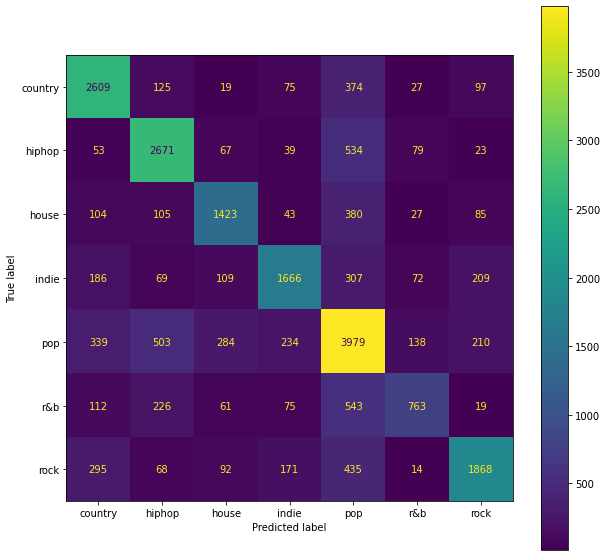

In [ ]:
conf_matrix = confusion_matrix(y_test, grid_rf.predict(X_test), labels=genre_order)
fig, ax = plt.subplots(figsize=(10, 10))
print(plot_confusion_matrix(X=X_test,y_true=y_test, labels=genre_order,estimator=grid_rf, ax=ax,values_format = 'd'))

Based on the above confusion matrix, we can see a few things:

1. Pop understandbly dominates the dataset. This somewhat obscures the confusion matrix because there are so many more pop rows than any other genre. We can see that based on the vertical light shade on the pop column (,4), our model is just blindly predicting pop in many cases where it's unsure. This poses a bit of an issue that I address on later.
2. Conversely, R&B is significantly underrepresented in the dataset. Only 769 tracks are predicted correctly as R&B, while 532 R&B tracks are incorrectly labeled as pop.
3. While the absolute number of tracks predicted in each square of the confusion matrix is interesting, it would be more useful to see the proportion of true tracks in each square. For example, I want to see the percentage of true R&B tracks that are predicted as R&B, rather than the absolute number of tracks, so the matrix is more balanced. Thus in the following block, I outputted the accuracy scores as well as the proportional confusion matrix.

The best score is 0.6387706791389105
The best hyper parameter setting is {'n_estimators': 500}
Model Accuracy: 0.6806779969099337

Accuracy predicting country : 0.7844257366205653
Accuracy predicting hiphop : 0.7706289671090595
Accuracy predicting house : 0.6566682048915552
Accuracy predicting indie : 0.6363636363636364
Accuracy predicting pop : 0.6996659046949182
Accuracy predicting r&b : 0.42412451361867703
Accuracy predicting rock : 0.6347264695888549


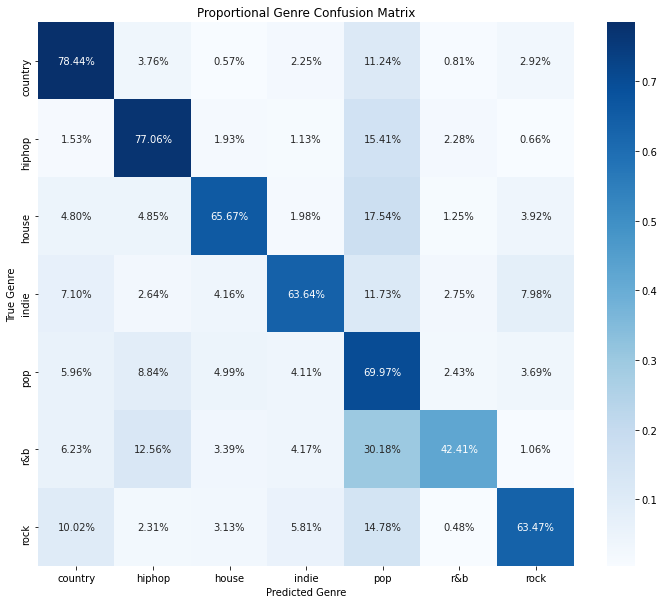

In [ ]:
print_grid_results(grid_rf,X_test,y_test)

The rudamentary RF model gives us a baseline performance of 68% in predicting the correct genre of a track.

Additionally, this proportional confusion matrix is a bit more readable. Additionally, this further emphasizes the model's tendancy to overpredict pop due to its prevalence in the dataset. In fact, when we look at what genre is most often miscategorized for each track, we see the

In [ ]:
for count,genre_preds in enumerate(conf_matrix):
  print("True Genre:", genre_order[count])
  genre_preds[list(genre_preds).index(max(genre_preds))] = 0
  incorrect_guess = genre_order[list(genre_preds).index(max(genre_preds))]
  print("Most Common Incorrect Prediction:", incorrect_guess)
  print("Percent of All Incorrect Predictions as", incorrect_guess, (max(genre_preds) / sum(genre_preds)))
  print()

True Genre: country
Most Common Incorrect Prediction: pop
Percent of All Incorrect Predictions as pop 0.5216178521617852

True Genre: hiphop
Most Common Incorrect Prediction: pop
Percent of All Incorrect Predictions as pop 0.6716981132075471

True Genre: house
Most Common Incorrect Prediction: pop
Percent of All Incorrect Predictions as pop 0.510752688172043

True Genre: indie
Most Common Incorrect Prediction: pop
Percent of All Incorrect Predictions as pop 0.3224789915966387

True Genre: pop
Most Common Incorrect Prediction: hiphop
Percent of All Incorrect Predictions as hiphop 0.29449648711943793

True Genre: r&b
Most Common Incorrect Prediction: pop
Percent of All Incorrect Predictions as pop 0.5241312741312741

True Genre: rock
Most Common Incorrect Prediction: pop
Percent of All Incorrect Predictions as pop 0.4046511627906977



Clearly, pop is dominating the dataset and overpowering the importance of less frequently occuring genres like R&B and house. Let's address that...

## Balancing the Dataset

Before optimizing the model's hyperparameters, I wanted to try to even out the distribution of tracks of each genre. I chose to test several outcomes and monitor how the model performed with each:
1. Only undersampling pop tracks
2. Upsampling lesser occuring genres to balance the number of tracks for each genre

### 1. Undersampling pop to 10,000 tracks



In [10]:
from sklearn.utils import resample

In [11]:
msk = np.random.rand(len(track_table_dummies)) < 0.75
train = track_table_dummies[msk]
test = track_table_dummies[~msk]

In [12]:
train.master_popular_genre.value_counts()

pop        12885
hiphop      7962
country     7585
rock        6785
indie       5740
house       4879
r&b         4161
Name: master_popular_genre, dtype: int64

In [13]:
df_nonpop = train[train['master_popular_genre']!='pop']
df_pop = train[train['master_popular_genre']=='pop']
samp = 8000
# Downsample majority class
train = resample(df_pop, 
                 replace=False,    # sample without replacement
                 n_samples=samp) # reproducible results
 
# Combine minority class with downsampled majority class
train = pd.concat([train, df_nonpop])
 
# Display new class counts
train.master_popular_genre.value_counts()

pop        8000
hiphop     7962
country    7585
rock       6785
indie      5740
house      4879
r&b        4161
Name: master_popular_genre, dtype: int64

In [14]:
X_train = train.iloc[:,1:]
y_train = train.iloc[:,0]
X_test = test.iloc[:,1:]
y_test = test.iloc[:,0]


rf_param_grid = {
       #'n_estimators': range(350, 700, 100),
       'n_estimators': [1600]
}
grid_rf_under = GridSearchCV(RandomForestClassifier(), rf_param_grid, cv=3).fit(X_train, y_train)

Undersampling pop tracks:
The best score is 0.44748788869885453
The best hyper parameter setting is {'n_estimators': 1600}
Model Accuracy: 0.6788518008030203

Accuracy predicting country : 0.8107438016528926
Accuracy predicting hiphop : 0.8380332610267535
Accuracy predicting house : 0.7351515151515151
Accuracy predicting indie : 0.6652871184687015
Accuracy predicting pop : 0.5277777777777778
Accuracy predicting r&b : 0.5476190476190477
Accuracy predicting rock : 0.6851512373968836


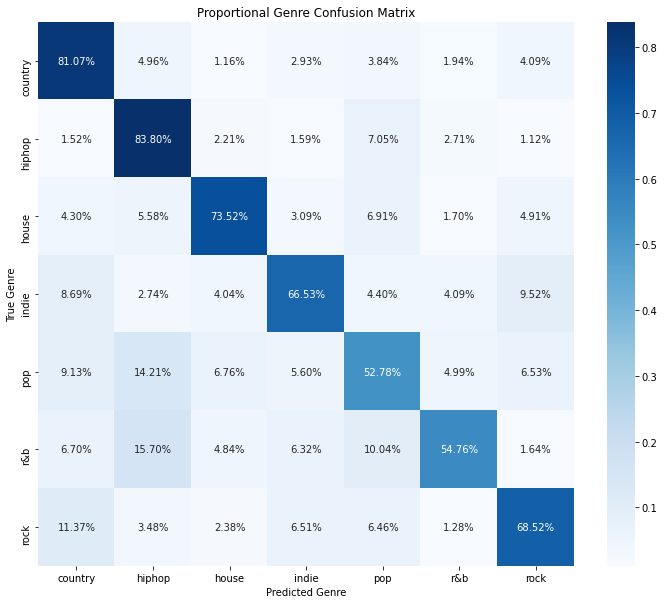

In [15]:
print("Undersampling pop tracks:")
print_grid_results(grid_rf_under,X_test,y_test)

While the confusion matrix looks a bit more balanced and there isn't a strong overprediction in the pop genre, the accuracy did not improve much -- it's still 68%. Interesting to note, the performance of pop dropped a bit because the model is not just predicting pop when it was unsure of the genre. It was better at predicting country and R&B, though

### 2. Oversampling r&b, house, indie, and rock to ~10,000 tracks
Next, I used SMOTE in order to generate synthetic rows to train on for the underrepresented classes. This essentially creates a training sample with the same number of tracks for each genre.

In [12]:
from imblearn.over_sampling import SMOTE

In [18]:
from sklearn import datasets
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix

def evaluate_model(X_train, y_train, model):
    preds = model.predict(X_test)
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring="accuracy")
    diff = scores.mean() - model.score(X_test, y_test)
    SD = diff / scores.std()
    print(f"Cross V Score: {scores.mean()} +/- {scores.std()}")
    print(f"Testing Score: {model.score(X_test, y_test)}")
    print(f"Cross & Test Diff: {diff}")
    print(f"Standard Deviations Away: {SD}")
    print(confusion_matrix(y_test, preds))

In [19]:
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

I had to employ a bit different of an approach to train this model. Because I did not want validate or test on the oversampled dataset, I used a pipeline to first apply SMOTE to the training data, then validate on non-SMOTE data, then test on non-SMOTE data.

In [ ]:
from imblearn.pipeline import make_pipeline
X = track_table_dummies.iloc[:,1:]
y = track_table_dummies.iloc[:,0]

rf = make_pipeline(SMOTE(random_state=0), 
                    GridSearchCV( RandomForestClassifier(),
                                 param_grid={'n_estimators': [1600],'max_depth': [100]},
                                 verbose=2,
                                 cv=3,
                                 refit=True))

rf.fit(X_train, y_train)

In [23]:
preds = rf.predict(X_test)
print(f"Testing Score: {rf.score(X_test, y_test)}")
print(confusion_matrix(y_test, preds))

Testing Score: 0.6776788148686722
[[2649  135   22   91  226   74  129]
 [  68 2714   92   50  339  168   35]
 [ 118  110 1517   53  186   65  118]
 [ 187   69  119 1671  164  142  266]
 [ 403  587  347  276 3405  332  337]
 [ 128  217   67   92  275  988   32]
 [ 298   83  106  192  241   54 1969]]


Model Accuracy: 0.6776788148686722

Accuracy predicting country : 0.796452194828623
Accuracy predicting hiphop : 0.7830351990767456
Accuracy predicting house : 0.7000461467466543
Accuracy predicting indie : 0.6382734912146677
Accuracy predicting pop : 0.5987339546333743
Accuracy predicting r&b : 0.5491939966648138
Accuracy predicting rock : 0.6690451919809718


Text(0.5, 1.0, 'Proportional Genre Confusion Matrix')

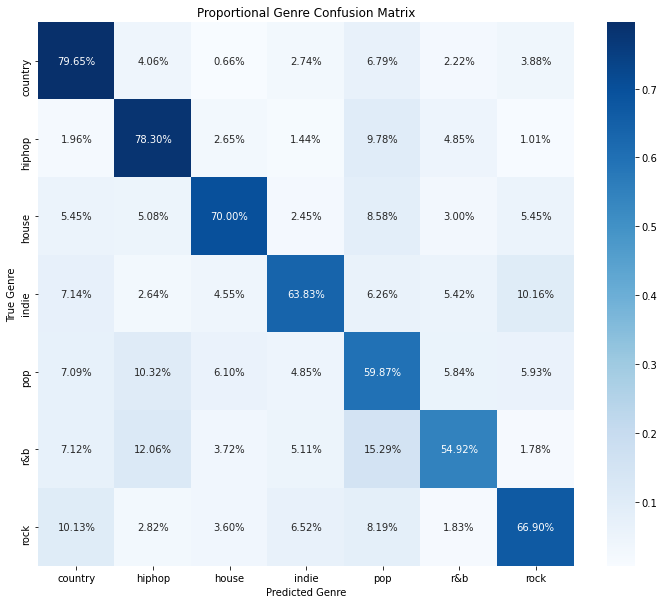

In [24]:
print("Model Accuracy:", accuracy_score(y_test,rf.predict(X_test)))
conf_matrix = confusion_matrix(y_test, rf.predict(X_test), labels=genre_order)
print()
for i in range(0,len(genre_order)):
  print_accuracy(i,conf_matrix)
fig, ax = plt.subplots(figsize=(12,10)) 
sns.heatmap(conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis], annot=True,fmt='.2%', cmap='Blues',xticklabels=genre_order,yticklabels=genre_order, ax=ax)
ax.set(xlabel='Predicted Genre', ylabel='True Genre')
ax.set_title("Proportional Genre Confusion Matrix")

Unfortunately, using this oversampling method surprisingly lowers the accuracy slightly overall, but we can see that the predictions are a bit more balanced. The model does not default to pop as often, but the accuracy in predicting true pop tracks clearly suffered. While the overall accuracy of this approach did not improve much, I feel that its still an improvement on the initial model that just blindly predicts pop for unclear tracks.

##What model is *best* here?

One thing to consider here is which of the above datasets to use to train the final model. The following three had roughly the same test accuracy (~68%).
* Method #1, no changes to the data. Pop made up by far the most tracks.
* Method #2, in which pop was downsampled to the amount of other genres
* Method #3, in which underrepresented genres were oversampled synthetically AND pop was downsampled

The benefits of using Method #1 is that the model has been trained on a higher proportion of pop relative to the other tracks. Given the prevalance of pop music in general, one might consider this a more accurate representation of the data that this model would typically see if given a real-world sample of tracks on Spotify. So if the use case of the model was to intake random tracks on Spotify to categorize them on genre, this approach would make some sense. The drawbacks of using the initial dataset is that the overemphasis of pop causes the model to just default to pop when in doubt. This feels like a bit of a lazy approach and more likely to fail if we wanted the model to be fed a single unknown track of any genre and get the best result. It generally performs worse on non-pop tracks.

Method #2, where pop was downsampled, had the best accuracy for non-pop genres like country and rock, but struggled a bit more for pop. This may lean too far into undermphasizing the importance of pop music. This model likely has a better pure understanding of what audible qualities make up each genre, but struggles to classify pop, which is the most common genre of music on Spotify.

The benefits of using Method #3 is that it most likely produces the best blend of emphasizing the imporance of pop tracks while not sacrificing the accuracy of predicting other genres.

I chose method #3 to build the model, as my goal was to most accurately predict a single song's genre while still considering the liklihood that a randomly selected song would be pop. I think the approach of balancing all input tracks to around 10,000 makes the most sense for this purpose

##Let's see some predictions

Now, let's analyze the performance a bit more and take a look at what tracks the model is right and wrong about. We can even listen to some of them on Spotify and see how we would classify them ourselves.

In [31]:
preds = []
for prediction in rf.predict_proba(X_test):
  pred_ind = []
  prediction = list(prediction)
  pred_ind.append(max(prediction))
  pred_ind.append(prediction.index(max(prediction)))
  preds.append(pred_ind)

for pred in preds:
  pred[1] = genre_order[pred[1]]

In [32]:
in_list = []
for i in range(0,len(preds)):
  in_list.append(int(list(y_test)[i] == preds[i][1]))

In [33]:
prediction_conf = []
predicted_genre = []

for i in range(0,len(y_test)):
  prediction_conf.append(preds[i][0])
  predicted_genre.append(preds[i][1])


prediction_frame = pd.DataFrame({"Prediction Confidence":prediction_conf,
                                 "Predicted Correctly":in_list,
                                 "True Genre": y_test,
                                 "Predicted Genre": predicted_genre,
                                 "Track Name": track_table.track_name[y_test.index],
                                 "Artist Name": track_table.art_name[y_test.index]})

Let's first look at what songs the model was confident in. There are many songs that the RF outputted a predicted probability of 1, meaning that the model was very confident in these predictions.

In [34]:
prediction_frame.drop_duplicates().sort_values(by="Prediction Confidence", ascending=False).head(20)

,Prediction Confidence,Predicted Correctly,True Genre,Predicted Genre,Track Name,Artist Name
56764,1.000000,1,r&b,r&b,Can We (with Kacy Hill),Jim-E Stack
15067,0.999375,1,r&b,r&b,Polaroids,Jay Prince
41737,0.998750,1,indie,indie,Song For Zula,Phosphorescent
55149,0.997500,1,r&b,r&b,John Redcorn,SiR
31808,0.997500,1,rock,rock,Out of My League,Fitz and The Tantrums
62145,0.996875,1,rock,rock,Too Late,The Happy Fits
41179,0.996875,1,rock,rock,Pompeii,Bastille
13424,0.996250,1,hiphop,hiphop,I Mean It (feat. Remo),G-Eazy
2640,0.996250,1,country,country,This Is How We Roll,Florida Georgia Line
33747,0.996250,1,indie,indie,Multi-Love,Unknown Mortal Orchestra


Here is the track by Jim-E Stack that the model correctly predicted as R&B: [Can We (with Kacy Hill) - Jim-E Stack](https://open.spotify.com/track/5mVWKI0OgsFIXF8aJccfO8?si=67ac936034124432)

Here is a track by Fitz and The Tantrums that the model correctly predicted as Rock: [Out of My League	Fitz and The Tantrums](https://open.spotify.com/track/2AYEOC02WLhUiOoaig2SEH?si=5abe7f31926b4f06)

Here is a track by Phosphorescent that the model correctly predicted as Indie: [Song For Zula - Phosphorescent](https://open.spotify.com/track/3zr2s3o2Ye1j6t0ZMdoUYi?si=c32ad6ac6c644a23)

These both make sense, as they sound quintessentially R&B, Rock and Indie. More interesting will be looking at what tracks the model predicted *incorrectly*. Let's take a look at a few of those.

In [35]:
prediction_frame[prediction_frame['Predicted Correctly'] == 0].drop_duplicates().sort_values(by="Prediction Confidence", ascending=False).head(20)

,Prediction Confidence,Predicted Correctly,True Genre,Predicted Genre,Track Name,Artist Name
5090,0.959375,0,pop,country,Suitcase,Steve Moakler
22411,0.920625,0,pop,house,Dechorro,Deorro
46362,0.918750,0,pop,hiphop,Press,Cardi B
21006,0.913750,0,pop,house,Flying Blind,Cosmic Gate
20731,0.908750,0,pop,house,Raise Your Head,Alesso
27593,0.903125,0,house,country,Gonna Be Alright - Man Cub Remix,Tritonal
21701,0.902500,0,pop,house,Lights,Swedish House Mafia
23005,0.898750,0,pop,house,This Is What It Feels Like - W&W Remix,Armin van Buuren
22833,0.893750,0,pop,house,In My Eyes - Original Mix,MitiS
21121,0.891875,0,pop,house,Fight The Fire - Original Mix,Andy Moor


Unsurprisingly, most of these missed predictions are true-genre pop. This is clearly the model's worst category at predicting, thought this was expected after we went with the Method #2 approach. Let's listen to a few of these in particular:

The first one in the list sounds a lot like country to me, despite its genre label being pop: [Suitcase -	Steve Moakler](https://open.spotify.com/track/0uhxXyG4Eb5sIIt3GZxJcn?si=f3c81e3fc9004886) The line between country, pop, and country-pop is certainly a blurry one, and this may be more of a failure of my labeling system rather than one by the model.

Let's look at a track that isn't true-genre pop. This one is true-genre house: [Gonna Be Alright - Man Cub Remix	Tritonal](https://open.spotify.com/track/3wJYhSVsFnfKr46ufuZgjA?si=6b74d547dfc34868) This is a surprising one. This is a fairly obvious pop or house track, so it's quite surprising that the model labeled this country. This is a pretty bad miss.

Finally, this Cardi B song is a bit of a surprise: [Press - Cardi B](https://open.spotify.com/track/6dPyzkyZwoj9LqjQXOFdVv?si=ab252432ee5f4544). I would definitely have labeled this as hiphop, so this is another understandable mistake by the model. This seems to be more of a case of an unclear distinction between pop/hiphop or a mistake on the genre labeling.

#Predict 2 Genres
As a last little experiment, I wanted to see how accurate the model would be if it was able to make 2 predictions for a track -- the 2 genres which it views as the most likely for that track.

In [37]:
# Add prediction of 2nd highest probability genre
two_preds = []
for prediction in rf.predict_proba(X_test):
  prediction = list(prediction)
  two_maxes = []
  two_maxes.append(prediction.index(max(prediction)))
  prediction[prediction.index(max(prediction))] = 0
  two_maxes.append(prediction.index(max(prediction)))
  two_preds.append(two_maxes)

In [38]:
# Convert probability to genre name
for pred in two_preds:
  pred[0] = genre_order[pred[0]]
  pred[1] = genre_order[pred[1]]

In [39]:
# Create list to evaluate accuracy
in_list = []
for i in range(0,len(two_preds)):
  in_list.append(int(list(y_test)[i] in two_preds[i]))

In [40]:
print("Accuracy:" , sum(in_list) / len(in_list))

Accuracy: 0.8220030900663455


With 2 predictions, the model improves about 14% to an 82% accuracy. That's pretty awesome, considering there are 7 different genres to consider for this multiclass labeling. Pretty cool! I wonder what ~18% of tracks are mislabeled here too. These would be tracks where the model really missed badly.

In [ ]:
pred_correctly = []
true_genre = []
predicted_genre = []

for i in range(0,len(y_test)):
  pred_correctly.append(in_list[i])
  true_genre.append(list(y_test)[i])
  predicted_genre.append(two_preds[i])

prediction_frame = pd.DataFrame({"Predicted Correctly":pred_correctly,
                                 "True Genre": true_genre,
                                 "Predicted Genres": predicted_genre,
                                 "Track Name": track_table.track_name[y_test.index],
                                 "Artist Name": track_table.art_name[y_test.index]})

In [42]:
display(prediction_frame[prediction_frame["Predicted Correctly"] == 0])

,Predicted Correctly,True Genre,Predicted Genres,Track Name,Artist Name
2885,0,country,"[hiphop, pop]",Smoke Stack,The Lacs
22986,0,house,"[country, pop]",Mono in Love - Radio Edit,Edward Maya
52843,0,hiphop,"[house, rock]",Tattoo,Kevin Abstract
57048,0,r&b,"[pop, hiphop]",Dingo X BIBI - she got it,BIBI
33048,0,pop,"[house, rock]",Gooey Rework,Glass Animals
...,...,...,...,...,...
2238,0,country,"[r&b, pop]",Telescope,Nashville Cast
7861,0,country,"[r&b, pop]",Mother,Sugarland
19231,0,hiphop,"[pop, house]",I've Been Waiting (feat. ILOVEMAKONNEN) - Orig...,Lil Peep
31310,0,indie,"[pop, rock]",We Must Be Killers,Mikky Ekko


Let's check some of these out:
*   [Smoke Stack - The Lacs](https://open.spotify.com/track/2XBYAG0RgFgzONthKkuaT5?si=d00724b4fac74469) - This one makes sense as a hiphop/pop track, as it's a pretty strange rap country fusion. 
*   [Tattoo - Kevin Abstrac](https://open.spotify.com/track/2jEkD23p3LVw2D19OiFvMK?si=460fea7143af495b) - This example again makes sense why the model would miss it. The sound features an acoustic guitar and pretty traditional rock drums, although it's strange that the model predicted house and not something like Indie/Rock.
*   [Boogieman - Childish Gambino](https://open.spotify.com/track/0SunFlwqT44E0BU0yrgM7u?si=5c52a9b7638143e7) - This one makes sense as just an extremely difficult song to predict. I would personally call this funk, perhaps? Of our genre's, I think hiphop is a fair true labell, but I'm not surprised the model missed this, given its unconventional sound.



## How to improve the model in the future
It seems that the best place to focus on for future improvement of the genre predicting model would be to improve the true labeling of the tracks. Detailed in part 1, every track / artist outputted by the Spotify API has a number of genre tags, but there is not a single definitive genre for one track. To allow us to build a genre-predicting algorithm, the track genre tags were pooled into a dictionary and I chose the most occuring gender to determine the True Genre for that track. This is somewhat imperfect and likely lead to some faulty labeling of true genre. However, this was the best option available until Spotify labels the genre of the track themselves, or I come up with some other NLP improvements for the tag text.